In [1]:
import carla
import random

client = None
# Connect to the client and retrieve the world object
client = carla.Client('127.0.0.1', 2000)
#client.set_timeout(50.0)
world = client.get_world()
spawn_points = world.get_map().get_spawn_points()


In [3]:
#this crashes
#client.load_world('Town05')

# Get the map's spawn points



In [3]:
loc = spawn_points[4].location
spectator = world.get_spectator()
spectator.set_transform(carla.Transform(loc))

In [20]:
# Retrieve the spectator object


# Get the location and rotation of the spectator through its transform
transform = spectator.get_transform()

location = transform.location
rotation = transform.rotation

# Set the spectator with an empty transform
spectator.set_transform(carla.Transform())
# This will set the spectator at the origin of the map, with 0 degrees
# pitch, yaw and roll - a good way to orient yourself in the map

In [6]:
# Get the blueprint library and filter for the vehicle blueprints
vehicle_blueprints = world.get_blueprint_library().filter('*vehicle*')
vehiclelist = []
for vehicle in vehicle_blueprints:
    vehiclelist.append(vehicle.id)
vehiclelist.sort()
print(vehiclelist)

['vehicle.audi.a2', 'vehicle.audi.etron', 'vehicle.audi.tt', 'vehicle.bh.crossbike', 'vehicle.bmw.grandtourer', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.firetruck', 'vehicle.chevrolet.impala', 'vehicle.citroen.c3', 'vehicle.diamondback.century', 'vehicle.dodge.charger_2020', 'vehicle.dodge.charger_police', 'vehicle.dodge.charger_police_2020', 'vehicle.ford.ambulance', 'vehicle.ford.crown', 'vehicle.ford.mustang', 'vehicle.gazelle.omafiets', 'vehicle.harley-davidson.low_rider', 'vehicle.jeep.wrangler_rubicon', 'vehicle.kawasaki.ninja', 'vehicle.lincoln.mkz_2017', 'vehicle.lincoln.mkz_2020', 'vehicle.mercedes.coupe', 'vehicle.mercedes.coupe_2020', 'vehicle.mercedes.sprinter', 'vehicle.micro.microlino', 'vehicle.mini.cooper_s', 'vehicle.mini.cooper_s_2021', 'vehicle.mitsubishi.fusorosa', 'vehicle.nissan.micra', 'vehicle.nissan.patrol', 'vehicle.nissan.patrol_2021', 'vehicle.seat.leon', 'vehicle.tesla.cybertruck', 'vehicle.tesla.model3', 'vehicle.toyota.prius', 'vehicle.vespa.

: 

In [22]:


# Spawn 50 vehicles randomly distributed throughout the map 
# for each spawn point, we choose a random vehicle from the blueprint library
#for i in range(0,20):
world.try_spawn_actor(random.choice(vehicle_blueprints), spawn_points[4])

In [17]:
ego_vehicle = world.spawn_actor(random.choice(vehicle_blueprints), spawn_points[4])

NameError: name 'vehicle_blueprints' is not defined

In [6]:
# Create a transform to place the camera on top of the vehicle
camera_init_trans = carla.Transform(carla.Location(x=1.5, z=2.4))

# We create the camera through a blueprint that defines its properties
camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
camera_bp.set_attribute('image_size_x', str(800 - (800 % 64)))  # 800 is the nearest multiple of 64
camera_bp.set_attribute('image_size_y', str(600 - (600 % 64)))  # 608 is the nearest multiple of 64
camera_bp.set_attribute('fov', '90')

# Define a callback to save the camera images to disk
def save_image(image):
    image.save_to_disk('D:/SelfDrivingImages/output/%06d.png' % image.frame)

# We spawn the camera and attach it to our ego vehicle
camera = world.spawn_actor(camera_bp, camera_init_trans, attach_to=ego_vehicle)

camera.listen(lambda image: save_image(image))
ego_vehicle.set_autopilot(True)

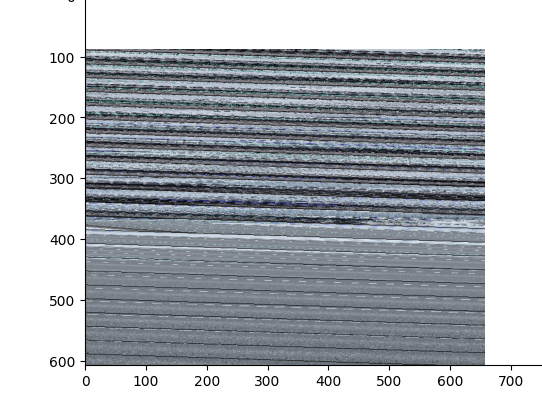

In [9]:
camera.destroy()

In [4]:
for vehicle in world.get_actors().filter('*vehicle*'):
    print(vehicle.type_id)
    #vehicle.set_autopilot(True)
    #vehicle.destroy()

vehicle.nissan.micra


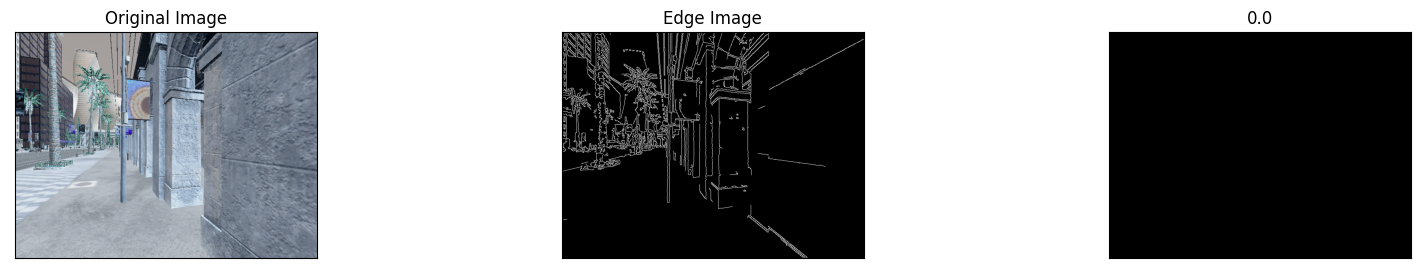

In [85]:
import carla
import random
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import math
from numpy import isnan
blueprint_library = world.get_blueprint_library()
vehicle_bp = random.choice(blueprint_library.filter('vehicle.bmw.grandtourer'))
spawn_point = random.choice(world.get_map().get_spawn_points())
vehicle = world.spawn_actor(vehicle_bp, spawn_points[4])

def process_img(image):
    i = np.array(image.raw_data)
    i2 = i.reshape((image.height, image.width, 4))
    i3 = i2[:, :, :3]
    return i3

cam_bp = blueprint_library.find('sensor.camera.rgb')
cam_bp.set_attribute('image_size_x', str(800 - (800 % 64)))  # 800 is the nearest multiple of 64
cam_bp.set_attribute('image_size_y', str(600 - (600 % 64)))  # 608 is the nearest multiple of 64
cam_bp.set_attribute('fov', '90')
cam_location = carla.Location(2,0,1)
cam_rotation = carla.Rotation(0,0,0)
cam_transform = carla.Transform(cam_location, cam_rotation)
camera_init_trans = carla.Transform(carla.Location(x=1.5, z=2.4))
camera = world.spawn_actor(cam_bp, camera_init_trans, attach_to=vehicle)

# def show_camera(image):
#     image = process_img(image)
#     plt.imshow(image)
#     plt.show()
#     clear_output(wait=True)

#Function to calculate the steering angle from the detected lines
def calculate_steering_angle(lines, image_shape):
    # If no lines were detected, return a default steering angle
    if lines is None:
        return 0.0

    # Initialize lists to store the slopes and intercepts of the lines
    slopes = []
    intercepts = []

    # Iterate over the lines
    for line in lines:
        for x1, y1, x2, y2 in line:
            # Calculate the slope and intercept for each line
            slope = abs((y2 - y1) / (x2 - x1))
            intercept = y1 - slope * x1
            slopes.append(slope)
            intercepts.append(intercept)

    # Calculate the average slope and intercept
    avg_slope = np.mean(slopes)
    avg_intercept = np.mean(intercepts)

    # Calculate the steering angle
    # For simplicity, let's assume that a positive slope requires a right turn
    # and a negative slope requires a left turn.
    # You will need to calibrate this based on your simulator setup and test.
    mid_x = image_shape[1] / 2
    mid_y = image_shape[0]
    lane_midpoint_x = (mid_y - avg_intercept) / avg_slope if avg_slope != 0 else mid_x
    direction = np.arctan((lane_midpoint_x - mid_x) / mid_y)
    steering_angle = direction / np.pi
    if isnan(steering_angle):
        return 0.0
    return steering_angle
# Define the region of interest (ROI)
def region_of_interest(img):
    height, width = img.shape
    mask = np.zeros_like(img)
    
    # Define a polygon for the mask, here a trapezoid
    polygon = np.array([[
        (0, height * 2 / 3),
        (width, height * 2 / 3),
        (width, height),
        (0, height),
    ]], np.int32)
    
    # Fill that polygon with white color
    cv2.fillPoly(mask, polygon, 255)
    
    # Bitwise AND between canny image and mask to get ROI
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image  

def is_line_approx_vertical(x1, y1, x2, y2):
    """
    Check if a line is approximately within 30 degrees of being vertical, ignoring its direction.

    Args:
    x1 (float): x-coordinate of the first point.
    y1 (float): y-coordinate of the first point.
    x2 (float): x-coordinate of the second point.
    y2 (float): y-coordinate of the second point.

    Returns:
    bool: True if the line is within 30 degrees of vertical, False otherwise.
    """
    try:
        absolute_slope = abs((y2 - y1) / (x2 - x1))
    except ZeroDivisionError:
        # The line is perfectly vertical
        return True

    # The tangent of 60 degrees, boundaries for being within 30 degrees of vertical
    tan_60_degrees = math.tan(math.radians(60))

    # Check if the absolute slope is greater than tan(60 degrees)
    return absolute_slope > tan_60_degrees



def show_camera(image):
    # Apply Gaussian blur
    image = process_img(image)
    #plt.imshow(image)
    #plt.show()
    clear_output(wait=True)
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

    # Perform edge detection
    edges = cv2.Canny(blurred_image, threshold1=100, threshold2=200)
    # Apply ROI on the edge image
    roi_image = region_of_interest(edges)

    # Perform Hough Transform to find lanes
    lines = cv2.HoughLinesP(
        roi_image,
        rho=1,              # Distance resolution in pixels
        theta=np.pi/180,    # Angle resolution in radians
        threshold=50,       # Min. number of intersecting points to detect a line
        lines=np.array([]), # Vector to return the start and end of lines
        minLineLength=5,    # Min. number of points to form a line
        maxLineGap=10       # Max. gap between lines to consider them as single line
    )
    filtered_lines = []
    
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                if(is_line_approx_vertical(x1, y1, x2, y2)):
                    filtered_lines.append(line)

    steering_angle = calculate_steering_angle(filtered_lines, image.shape)
    if(steering_angle == None):
        steering_angle = 0.0
    #print(steering_angle)
    #print(steering_angle)
    vehicle.apply_control(carla.VehicleControl(throttle=0.4, steer=steering_angle , brake=0.0, reverse=False))
    # Create an image to draw the lines
    lines_image = np.zeros_like(image)


    # Draw lines on the imageS
    if filtered_lines is not None:
        for line in filtered_lines:
            for x1, y1, x2, y2 in line:
                cv2.line(lines_image, (x1, y1), (x2, y2), (255, 0, 0), 3)

    plt.figure(figsize=(20, 10))
    plt.subplot(331), plt.imshow(image, cmap='gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(332), plt.imshow(edges, cmap='gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(333), plt.imshow(lines_image, cmap='gray')
    plt.title(steering_angle), plt.xticks([]), plt.yticks([])
    plt.show()



camera.listen(lambda image: show_camera(image))



In [3]:
vehicle.type_id

NameError: name 'vehicle' is not defined

True

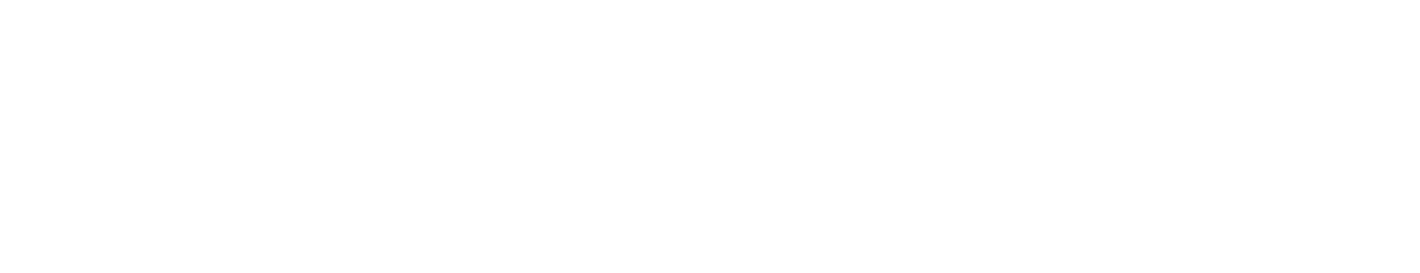

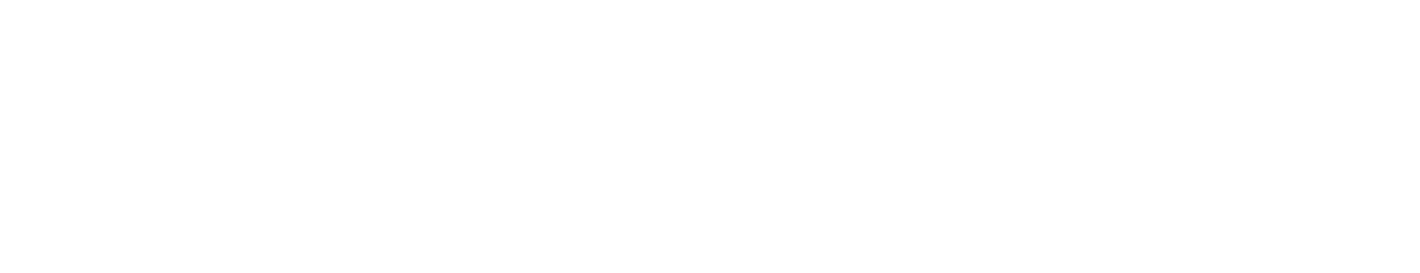

: 

In [86]:
camera.destroy()
vehicle.destroy()